# Polynomial Fitting 2 - Automatically Figuring out Degree of Polynomial

In Lesson 2, we wrote a function that could fit a polynomial of a given degree to a set of points.

The downside of this function, however, is that it requires us to specify the degree of the polynomial.

How can we make the model figure out the best degree of the polynomial itself?


## Maximum Likelihood Estimation

Read section 3 "Probabilistic Interpretation" in http://cs229.stanford.edu/notes/cs229-notes1.pdf

In [1]:
%%capture
#%run 'Lesson2Answers.ipynb' # Run this to "import" the code from your Lesson 2 solution. The %%capture suppresses the output.
%run "./Lesson2Answers.ipynb"

In [2]:
import types
try:
    # Verify that import worked.
    assert(type(fit_linear_regression) == types.FunctionType)
    assert(type(to_feature_vector) == types.FunctionType)
    assert(type(random_polynomial) == types.FunctionType)
    print("Import worked!")
except Exception as e:
    print(
        """
        Failed to import Lesson2!
        Remove the %%capture from the previous cell and run again to see error
        """
    )
    raise e

Import worked!


In [3]:
"""
Helper functions for you.
"""

import random
def to_design_matrix(x_values, degree):
    """
    Given an array of real numbers, convert them into feature
    vectors and stack them as row vectors to form a design matrix.
    """
    return np.array([to_feature_vector(x, degree) for x in x_values])

def evaluate_best_degree_pickers(picker_1, picker_2=None, show_charts=True):
    """
    Given a polynomial and some points sampled from it, fit a linear regression
    model whose degree is outputted by the degree_picker(x_values_validation, y_values_validation)
    function.
    
    Display the actual and predicted polynomial along with plots of the points
    and the predicted polynomial.
    
    Return the absolute difference between actual polynomial degree and predicted polynomial degree.
        If picker_2 is not None, return a pair of absolute differences.
    """
    params = dict(
        noise_sigma=0.001, 
        min_x=-100,
        max_x=100,
        num_points=2000,
    )
    polynomial, x_values, y_values = generate_dataset(**params)
    pickers = [picker_1]
    if picker_2 is not None:
        pickers.append(picker_2)
    best_degrees = [picker(x_values, y_values) for picker in pickers]
    
    params['polynomial'] = polynomial
    polynomial, x_values, y_values = generate_dataset(**params)
    
    picker_errors = [abs((d + 1) - len(polynomial)) for d in best_degrees]
    
    if show_charts:
        if picker_2 is not None:
            print("HERE IS YOUR NAIVE DEGREE PICKER")
        evaluate_linear_regression(polynomial, x_values, y_values, best_degrees[0])

        if picker_2 is not None:
            print("HERE IS YOUR SMART DEGREE PICKER")
            evaluate_linear_regression(polynomial, x_values, y_values, best_degrees[1])
    
    return tuple(picker_errors)

In [4]:
"""
Exercise 1: Log Likelihood.
"""
import numpy as np
import math

def compute_squared_error(X, y, theta):
    # Recall squared error = (X * theta - y).T * (X * theta - y)
    # @ means matrix multiplication
    z = (X @ theta) - y
    return z.T @ z

def compute_log_likelihood(X, y, theta, sigma=1.0):
    """
    Given a design matrix X of dimension m x d, labels of dimension m x 1,
    and a linear regression coefficient vector dimension d x 1, compute
    the log likelihood of the examples in the design matrix assuming the
    zero-mean Gaussian noise model described in the notes. The sigma
    value is provided as an argument.
    
    Logarithm is natural logarithm here.
    
    Some links that may help:
        https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.log.html
        https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.sqrt.html
        https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.shape.html
        https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.matmul.html
        https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.subtract.html
        https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.power.html
        https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.sum.html
        
   
    Do NOT implement this by computing the likelihood and taking the logarithm
    at the end. You need to compute the log-likelihood directly. The reason
    we do this is because the likelihood function involves multiplication
    of many numbers. If those numbers are small, we will get underflow (i.e. 
    the product will be really small and the computer will round it to zero because
    it can't represent numbers that small). If those numbers are large, we will
    get overflow. Since the log-likelihood uses addition it will not underflow and since
    applies a logarithm to each term, the summands will be small and the sum won't overflow.
    """
    m = len(X) # X = m x d
    # log (1 / n) = log(n ^ -1) = -log(n)
    offsetTerm = (-m * (numpy.log(math.sqrt(2 * math.pi * sigma))))
    squaredError = compute_squared_error(X,y,theta)
    seMult = -1.0 / (2 * sigma * sigma)
    return offsetTerm + seMult * squaredError


# Let's test your log likelihood implementation.
X = np.array([
    [1, 2, 3],
    [4, 5, 6],
])
y = np.array([
    [20],
    [32],
])
theta = np.array([
    [10],
    [20],
    [30],
])
expected_log_likelihood = -48673.837877066406
if abs(compute_log_likelihood(X, y, theta) - expected_log_likelihood) < 0.001:
    print("Implementation looks good!")
else:
    print("Implementation has a bug!")

Implementation looks good!


## Picking Polynomial Degree - Naive Solution

Now that we have a log-likelihood function, here's one approach to select the degree of the polynomial.

Let's try all the degrees between 0 and 20 and pick the one that maximizes the log likelihood.

In [5]:
"""
Exercise 2: Naive Polynomial Degree Picker
"""

def naive_degree_picker(x_values, y_values, min_degree=0, max_degree=20):
    """
    @param x_values - A numpy array of real numbers representing the x values.
    @param y_values - A numpy array of real numbers representing the y values.
        So, (x_values[i], y_values[i]) is a training example.
    
    @return The degree of the polynomial between min_degree and max_degree
    that achieves the maximum log-likelihood on the dataset.
    
    Hint: Use fit_linear_regression, compute_log_likelihood, and to_design_matrix
    """
    results = []
    currBest = None
    for degree in range(min_degree, max_degree+1):
        X = to_design_matrix(x_values, degree) #This computation is done twice, once in fit_linear_regression, once here
        # Would be more efficient to do it only once
        theta = fit_linear_regression(x_values, y_values, degree)
        y = y_values
        thisLL = compute_log_likelihood(X,y,theta) # Assume sigma is default
        results.append(thisLL)
        if currBest is None or thisLL > results[currBest]:
            # If the log-likelihood is equal, take the simpler polynomial
            # The most recently added likelihood is best
            currBest = len(results) - 1
    return currBest
    

Actual Polynomial:  f(x) = -0.9433511681257665 - 1.7498728398950565 * x^1 - 0.9535834759524695 * x^2 + 0.06031619946968014 * x^3 + 0.7268607136961203 * x^4 + 1.248092735475713 * x^5
Your Prediction:  f(x) = -0.9433882642319238 - 1.749871953742906 * x^1 - 0.9535834531776523 * x^2 + 0.0603161994590686 * x^3 + 0.7268607136933317 * x^4 + 1.248092735475696 * x^5 + 1.0881794164191415e-16 * x^6


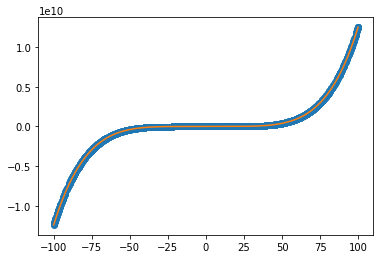

(1,)

In [6]:
"""
Exercise 3: Evaluate Naive Degree Picker.

Run this cell several times and look at the predicted polynomial vs. the actual
polynomial. How does the degree of your predicted polynomial compare to the degree of the actual polynomial?

ANSWER: It is higher, sometimes by a small amount (1 degree), 
sometimes even going so much as up to degree 20 to represent a degree 3 polynomial
"""

evaluate_best_degree_pickers(naive_degree_picker)

In [ ]:
"""
On average, let's see how good the naive solution is at getting the correct degree.

Note that this will be slow because it is training lots of regression models.
"""
import threading


N = 100

def single_threaded_get_differences():
    differences = [
        evaluate_best_degree_pickers(naive_degree_picker, picker_2=None, show_charts=False)[0] for i in range(N)
    ]
    return differences

def multi_threaded_get_differences(num_threads = 8):
    sem = threading.Semaphore(num_threads)
    sem2 = threading.Semaphore(0)
    # Threads might make this a little faster, since numpy doesn't need the global lock
    def do_evaluate_best_degree_pickers(outDictionary, outKey, *args, **kwargs):
        sem.acquire() # We wanna make a thread, so we need a thread
        def internal_run():
            ans = evaluate_best_degree_pickers(*args, **kwargs)
            outDictionary[outKey] = ans
            sem2.release()
            sem.release() # Return the thread
        threading.Thread(target=internal_run).start()

    diffDict = {}
    for i in range(N):
        # This will acquire N counts
        do_evaluate_best_degree_pickers(diffDict, i, naive_degree_picker, picker_2=None, show_charts=False)

    # We want them all back
    for i in range(N):
        sem2.acquire() # Will block until each and every thread has returned its semaphore

    differences = [diffDict[i][0] for i in range(N)]
    return differences

differences = multi_threaded_get_differences(8)
print(differences)

print(
    """
    On average, the absolute difference between the predicted degree and actual degree is {}
    """.format(sum(differences)/len(differences))
)

## Smarter Solution: Validation Set

The problem with our naive solution is that it fits the data WAY too closely. This is a problem in machine learning called **overfitting**. Basically, the model pays too much attention to the dataset and ends up fitting itself to both the real patterns in the data AND the noise in the data. We want a way to prevent our model from fitting the noise.

Here's one way we can do that.

Take our `(x, y)` pairs and randomly split them into two groups. The first group, called the training set, will have $P\%$ of the examples. The second group, called the validation set, will have the remaining $(100 - P)\%$ of the examples.

Now, here's what we will do for each degree value between 0 and 20.

1. Fit a linear regression model on the training set
2. Compute the log likelihood on the validation set.
3. Note down the (degree, log likelihood) pair.

Then, we select the degree that has the maximum validation log likelihood.

In practice $P$ is typically around 70% to 90%. In our case, we can set it much smaller because there's not a ton of noise in our dataset.

### Why Does This Work?

The key insight is that the model is validated on a set of examples DIFFERENT from the set it was trained on. Thus, if the model learns to fit noise in the data, then it will do poorly on the validation set because the noise will be totally different (noise is random, after all). However, if the model learns to fit useful patterns, then it will do well on the validation set because the same useful patterns will appear there too. In other words, we are forcing the model to do well on the training set, but not so closely that its learning cannot **generalize** to new data.

In [16]:
"""
Exercise 4: Split Dataset.
"""
import random
def split_dataset(x_y_pairs, split_fraction):
    """
    Given a set of (x, y) pairs, randomly put split_fraction fraction of them
    into x_y_train and the remainder into x_y_validation. Return the pair
    (x_y_train, x_y_validation).
    """
    x_y_pairs_shuffled = list(x_y_pairs)
    random.shuffle(x_y_pairs_shuffled)
    n = len(x_y_pairs_shuffled)
    training_size = int(split_fraction * n)
    return (x_y_pairs_shuffled[:training_size], x_y_pairs_shuffled[training_size:])
    

pairs = [(i, i**2) for i in range(1, 11)]
x_y_train, x_y_validation = split_dataset(pairs, 0.7)

print("Sampled these: ", x_y_train, x_y_validation)


# Ensure that the sizes are correct.
assert(len(x_y_train) == 7)
assert(len(x_y_validation) == 3)

# Ensure that every item is a pair.
assert(len([p for p in x_y_train if len(p) != 2]) == 0)
assert(len([p for p in x_y_validation if len(p) != 2]) == 0)

print("Everything looks good")

Sampled these:  [(5, 25), (10, 100), (4, 16), (9, 81), (3, 9), (2, 4), (8, 64)] [(7, 49), (6, 36), (1, 1)]
Everything looks good


In [24]:
"""
Exercise 5: Smarter Polynomial Degree Picker
"""

def smart_degree_picker(x_values, y_values, min_degree=0, max_degree=20, split_fraction=0.7):
    """
    @param x_values - An array of real numbers representing the x values.
    @param y_values - An array of real numbers representing the y values.
        So, (x_values[i], y_values[i]) is a training example.
    
    @return The degree of the polynomial between min_degree and max_degree
    that achieves the best log likelihood on the validation set.
    
    Hint: Use fit_linear_regression, compute_log_likelihood, and to_design_matrix
    Hint: Use list(zip(x_values, y_values)) to create x_y_pairs.
    Hint: Use list(zip(*x_y_pairs)) to split x_y_pairs apart into two lists.
    """
    # zip converts (all-x-values, all-y-values) into [(x1,y1),(x2,y2)], so on
    x_y_pairs = list(zip(x_values, y_values))
    training, validation = split_dataset(x_y_pairs, split_fraction)
    x_values_training, y_values_training = list(zip(*training))
    x_values_validation, y_values_validation = list(zip(*validation))
    results = []
    currBest = None
    for degree in range(min_degree, max_degree+1):
        X = to_design_matrix(x_values_validation, degree) #This computation is done twice, once in fit_linear_regression, once here
        # Would be more efficient to do it only once
        theta = fit_linear_regression(x_values, y_values, degree)
        y = y_values_validation
        thisLL = compute_log_likelihood(X,y,theta) # Assume sigma is default
        results.append(thisLL)
        if currBest is None or thisLL > results[currBest]:
            # If the log-likelihood is equal, take the simpler polynomial
            # The most recently added likelihood is best
            currBest = len(results) - 1
    return currBest
    
    

HERE IS YOUR NAIVE DEGREE PICKER
Actual Polynomial:  f(x) = -0.021857931453402202 + 0.029497556532120495 * x^1 + 0.28814963733498367 * x^2 - 0.9480813475750756 * x^3 + 0.1494898294541569 * x^4
Your Prediction:  f(x) = -0.021727490106776663 + 0.02949679461505379 * x^1 + 0.28814866442640275 * x^2 - 0.9480813429425173 * x^3 + 0.14948983087202064 * x^4 - 8.355474945621793e-13 * x^5 - 8.043787647972532e-13 * x^6 - 1.904813654930829e-15 * x^7 + 2.2216834205390327e-16 * x^8 + 1.0580635462359031e-18 * x^9 - 3.19616304660709e-20 * x^10 - 2.185236211340662e-22 * x^11 + 2.3043178077319733e-24 * x^12 + 1.9977514800652048e-26 * x^13 - 6.580017720560736e-29 * x^14 - 6.767694064428573e-31 * x^15


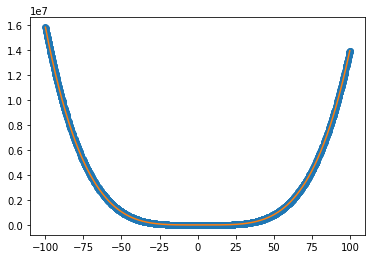

HERE IS YOUR SMART DEGREE PICKER
Actual Polynomial:  f(x) = -0.021857931453402202 + 0.029497556532120495 * x^1 + 0.28814963733498367 * x^2 - 0.9480813475750756 * x^3 + 0.1494898294541569 * x^4
Your Prediction:  f(x) = -0.021727490106776663 + 0.02949679461505379 * x^1 + 0.28814866442640275 * x^2 - 0.9480813429425173 * x^3 + 0.14948983087202064 * x^4 - 8.355474945621793e-13 * x^5 - 8.043787647972532e-13 * x^6 - 1.904813654930829e-15 * x^7 + 2.2216834205390327e-16 * x^8 + 1.0580635462359031e-18 * x^9 - 3.19616304660709e-20 * x^10 - 2.185236211340662e-22 * x^11 + 2.3043178077319733e-24 * x^12 + 1.9977514800652048e-26 * x^13 - 6.580017720560736e-29 * x^14 - 6.767694064428573e-31 * x^15


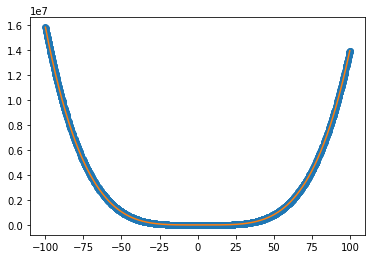

(11, 11)

In [27]:
"""
Exercise 6: Evaluate Smart Degree Picker.

Run this cell several times and look at the predicted polynomial vs. the actual
polynomial. How well does it fit the data? How does it compare to the Naive picker?

Sometimes much more accurate, sometimes not (off by 0 vs off by 14 in some observations, vs off by 8 & off by 9)
It still overfits, but less often
"""
evaluate_best_degree_pickers(naive_degree_picker, smart_degree_picker)

In [28]:
"""
On average, let's see how good the smarter solution is at getting the correct degree.

Note that this will be slow because it is training lots of regression models.
"""
N = 100
differences = [
    evaluate_best_degree_pickers(naive_degree_picker, picker_2=smart_degree_picker, show_charts=False)
    for i in range(N)
]
naive_differences, smart_differences = list(zip(*differences))
print(
    """
    NAIVE: On average, the absolute difference between the predicted degree and actual degree is {}
    """.format(sum(naive_differences)/len(naive_differences))
)
print(
    """
    SMART: On average, the absolute difference between the predicted degree and actual degree is {}
    """.format(sum(smart_differences)/len(smart_differences))
)


    NAIVE: On average, the absolute difference between the predicted degree and actual degree is 14.07
    

    SMART: On average, the absolute difference between the predicted degree and actual degree is 11.3
    
